# COVID-19 ANALYSIS

The Coronavirus disease 2019 (Covid-19) is caused by the virus SARS-CoV-2 and it was first reported in Wuhan, China in December 2019. The virus spreads through droplets produced when an infected person coughs or sneezes, and is transferred to another person through close contact like shaking hands, or touching. The spread of the virus can be prevented by frequently washing hands or using an alcohol based sanitizer, avoiding touching your face,
maintaining social distance and avoiding large gatherings. 

To combat the spread of the virus in South Africa, the government initialted a ban on all international travel, a strict lockdown that requires people to work from home and the compulsory use of face masks when going out in public. This report provides an analysis of the spread of the virus in South Africa from the 5th of March when the first case was reported. It shows how cases have evolved and what effect the lockdown and social distancing had on infection rates.

# Load libraries

In [42]:
import warnings
import folium
from datetime import datetime, date
from scipy.integrate import odeint
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from folium import plugins
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 12
init_notebook_mode(connected=True)


warnings.filterwarnings('ignore')

# Load data

In [142]:
#national_report = pd.read_csv('../data/nicd_daily_national_report.csv')
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')
transmission = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_transmission_type.csv')
hospitals = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/health_system_za_hospitals_v1.csv')
health_facilities = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/Other_health_facilities/CountHealthFacilitiesbyDistricts.csv')
reproductive_rate = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv')
mobility = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/mobility/google_mobility/mobility_report_ZA.csv')

In [90]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,confirmed,source
186,2020-09-09,20200909,87040.0,40456.0,213741.0,115372.0,13900.0,25311.0,12407.0,26580.0,107624.0,0.0,642431,https://twitter.com/nicd_sa/status/13037732622...


In [91]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,recovered,source
139,2020-09-09,20200909,82842,27129,188987,103437,12989,23917,9075,21673,99886,0,569935,https://twitter.com/nicd_sa/status/13037732622...


In [92]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,deaths,source
162,2020-09-09,20200909,3012,806,3860,2356,257,416,150,295,4016,0,15168,https://twitter.com/nicd_sa/status/13037732622...


In [93]:
transmission = transmission.drop(['Unnamed: 4'], axis = 1)
transmission.head(2)

,case_id,transmission_type,type,countries
0,1,Travelled to Italy,travel,italy
1,2,Travelled to Italy,travel,italy


In [94]:
lockdown['date'] = pd.to_datetime(lockdown['date'], format='%d-%m-%Y')
deaths.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,deaths,source
162,2020-09-09,20200909,3012,806,3860,2356,257,416,150,295,4016,0,15168,https://twitter.com/nicd_sa/status/13037732622...


In [96]:
# rename columns
confirmed = confirmed.rename(columns={'total': 'confirmed'})
recoveries = recoveries.rename(columns={'total': 'recovered'})
deaths = deaths.rename(columns={'total': 'deaths'})

# create a new dataframe with summary of cases
total_cases = pd.concat([confirmed['date'], confirmed['confirmed'],
                         recoveries['recovered'], deaths['deaths']], axis=1)

total_cases['recovered'] = total_cases['recovered'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

total_cases['recovered'] = total_cases['recovered'].fillna(0)
total_cases['deaths'] = total_cases['deaths'].fillna(0)

In [97]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       187 non-null    datetime64[ns]
 1   confirmed  187 non-null    int64         
 2   recovered  187 non-null    float64       
 3   deaths     187 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 6.0 KB


In [98]:
# calculate recovery and deaths rates, and create new columns
total_cases['active_cases'] = total_cases['confirmed'] - \
    total_cases['recovered'] - total_cases['deaths']
total_cases['recov_rate'] = (
    total_cases['recovered']/total_cases['confirmed'])*100
total_cases['death_rate'] = (
    total_cases['deaths']/total_cases['confirmed'])*100

# create a month column
total_cases['month'] = total_cases['date'].dt.month

# change month number to month name
total_cases['month'] = total_cases['month'].replace(3, 'March')
total_cases['month'] = total_cases['month'].replace(4, 'April')
total_cases['month'] = total_cases['month'].replace(5, 'May')
total_cases['month'] = total_cases['month'].replace(6, 'June')
total_cases['month'] = total_cases['month'].replace(7, 'July')
total_cases['month'] = total_cases['month'].replace(8, 'August')
total_cases['month'] = total_cases['month'].replace(9, 'September')

In [99]:
# create a dataframe with confirmed cases
confirmed_cases = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=[
                          'confirmed', 'recovered', 'deaths', 'active_cases']).rename(columns={
                              'variable': 'cases', 'value': 'number'})

# create a dataframe with death and recovery rates
death_recovery = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=[
                         'recov_rate', 'death_rate']).rename(columns={
                             'variable': 'cases', 'value': 'number'})

In [24]:
confirmed_cases.tail(), death_recovery.tail()

(          date      month   cases   number
 556 2020-09-05  September  deaths  14779.0
 557 2020-09-06  September  deaths  14889.0
 558 2020-09-07  September  deaths  15004.0
 559 2020-09-08  September  deaths  15086.0
 560 2020-09-09  September  deaths  15168.0,
           date      month       cases    number
 369 2020-09-05  September  death_rate  2.320517
 370 2020-09-06  September  death_rate  2.331809
 371 2020-09-07  September  death_rate  2.346714
 372 2020-09-08  September  death_rate  2.355564
 373 2020-09-09  September  death_rate  2.361032)

Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 525 242 recoveries and 13 502 deaths. 

# Data analysis

## Covid-19 time-line

First we look at a time-line of the important events related to Covid-19.The time-line starts on the 5th of March when the first case was confirmed and ends with the beginning of level 2 lockdown.

In [28]:
# create a list of events and dates
event = ['first positive case', 'travel ban', 'level 5 lockdown', 'alcohol ban', 'alcohol ban lifted',
         'level 4 lockdown', 'level 3 lockdown', 'alcohol ban lifted', 'level 2 lockdown', 'alcohol ban']
dates = ['2020-03-05', '2020-03-18', '2020-03-26', '2020-03-26', '2020-04-07',
         '2020-05-01', '2020-07-01', '2020-08-17', '2020-09-01', '2020-04-16']
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

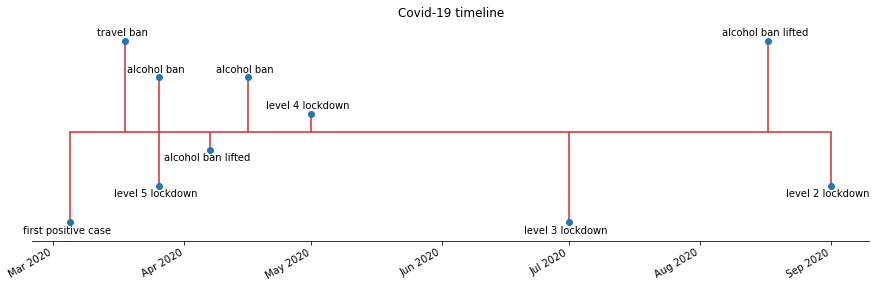

In [29]:
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(15, 4))
ax.set(title='Covid-19 timeline')

# create lines and set color to red
markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt='C3-',
                                         use_line_collection=True)

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, event, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords='offset points', va=va, ha='center')

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

The first positive case was confirmed on the th of March. This was followed by a travel ban and the closure of schools 13 days later. On the 15th of March the president declared a national state of disaster and prohibited large gatherings. This was followed by a strict lockdown (level 5) and an alcohol ban. Since the start of level 5 lockdown regulations have been eased gradually until level 2 lockdown.

## Confirmed cases 

Next we look at the confirmed cases split into recoveries, active cases and deaths.

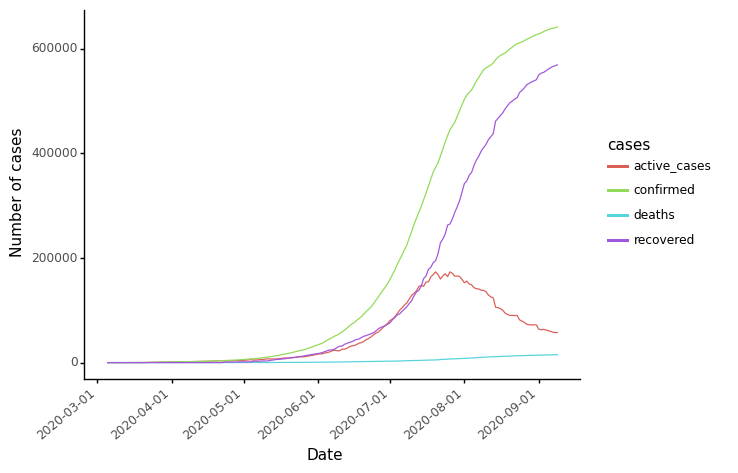

<ggplot: (96289024467)>

In [40]:
(ggplot(confirmed_cases, aes(x='date', y='number', color='cases'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

Positive cases were at a minimum approximately 2 months. We experienced an increase in positive cases between the beginning of June and mid-August, during Level 3 of lockdown. The number of cases has started to stabilise.

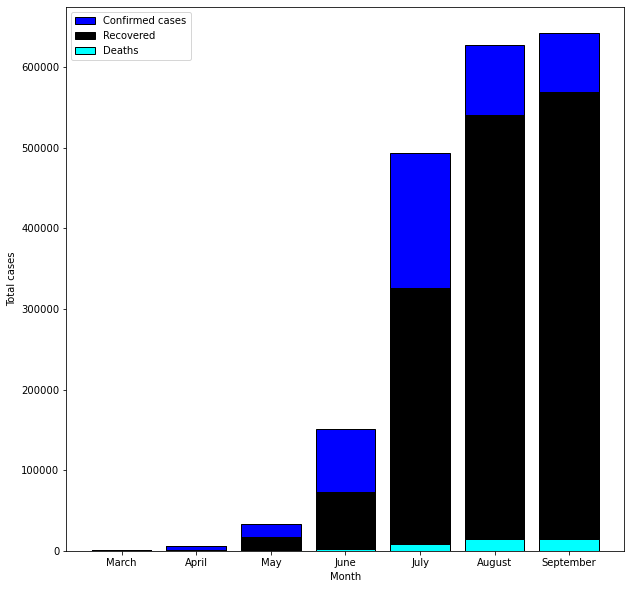

In [102]:
plt.figure(figsize=(10, 10))

# plot all cases in a bar graph
plt.bar(total_cases['month'], total_cases['confirmed'],
        color='blue', edgecolor='black', label='Confirmed cases')
plt.bar(total_cases['month'], total_cases['recovered'],
        color='black', edgecolor='black', label='Recovered')
plt.bar(total_cases['month'], total_cases['deaths'],
        color='cyan', edgecolor='black', label='Deaths')

plt.legend()

plt.ylabel('Total cases')
plt.xlabel('Month')

plt.show()

There has been a positive increase in the number of recoveries and a small proportion of confirmed cases resulted in death.

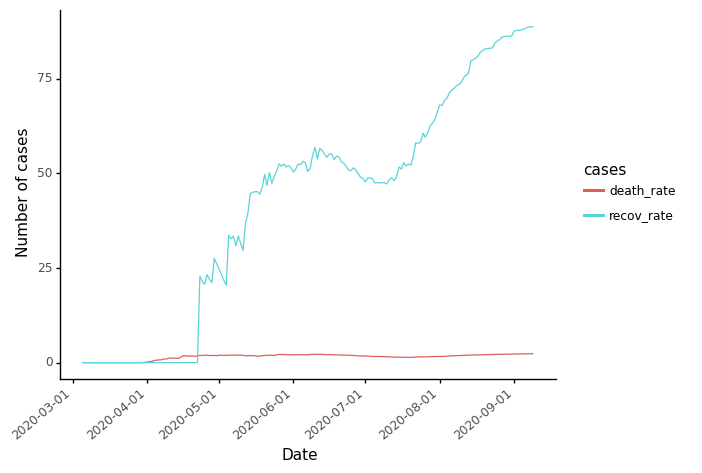

<ggplot: (-9223371936050999250)>

In [105]:
(ggplot(death_recovery, aes(x='date', y='number', color='cases'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()    
    + theme(axis_text_x=element_text(rotation=40, hjust=1))

 )

Even with the exponential increase in confirmed cases the death rate has been minimal, with only 2.2% of Covid-19 related deaths being reported to date.

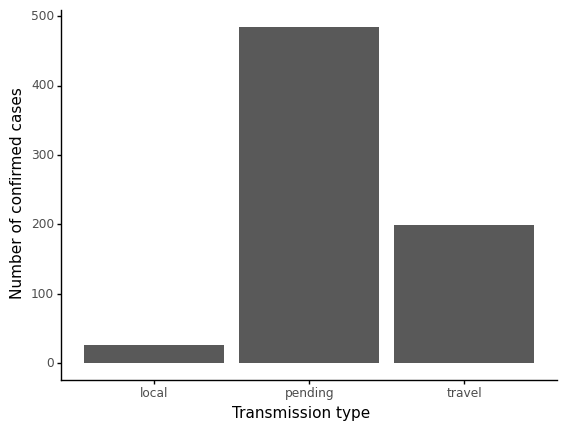

<ggplot: (100803202971)>

In [106]:
(ggplot(transmission, aes(x='type'))
 + geom_bar()
 + theme_classic()
 + xlab('Transmission type')
 + ylab('Number of confirmed cases')
)

An analysis of cases reported in mid-March (25 March 2020) showed that more people who tested positive for the virus had travelled abroad and contracted the virus in that period. This was before the travel ban was implemented. 

## Polynomial regression

In [51]:
# count the number of days from the first confirmed case
total_cases['days'] = [i+1 for i in range(len(total_cases))]

# split the data into x and y variables
X = total_cases['days']
y = total_cases['confirmed']

# convert x and y into an array
X = np.array(X)
y = np.array(y)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [54]:
reg = PolynomialFeatures(degree=4)
X_poly = reg.fit_transform(X)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y)

LinearRegression()

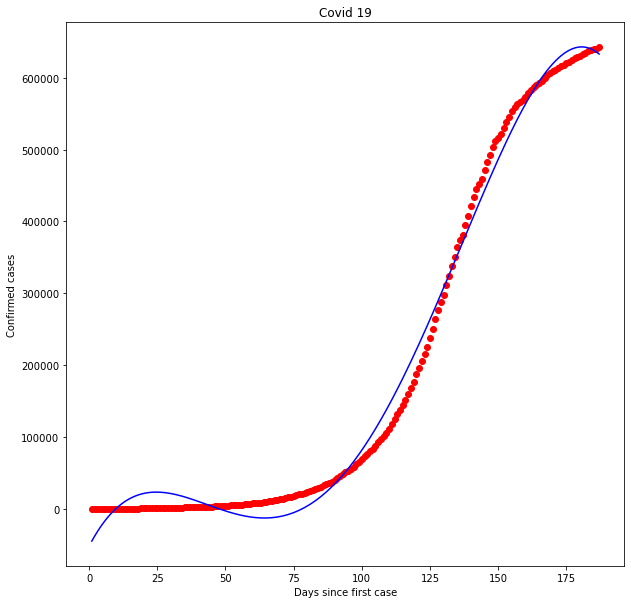

In [57]:
plt.figure(figsize=(10, 10))

plt.scatter(X, y, color='red')
plt.plot(X, lin_reg_2.predict(reg.fit_transform(X)), color='blue')
plt.title('Covid 19')
plt.xlabel('Days since first case')
plt.ylabel('Confirmed cases')
plt.show()

The cumulative number of cases follows a polynomial regression. 

## District data

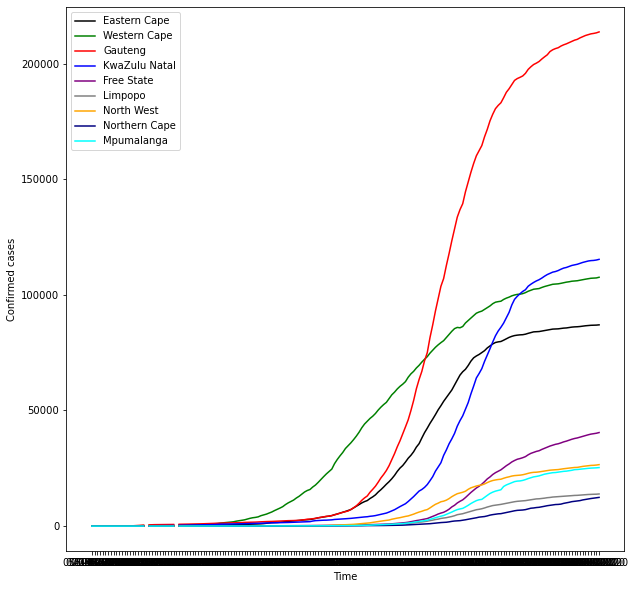

In [196]:
plt.figure(figsize=(10,10))

plt.plot(confirmed['date'], confirmed['EC'],
         color='black', label='Eastern Cape')
plt.plot(confirmed['date'], confirmed['WC'],
         color='green', label='Western Cape')
plt.plot(confirmed['date'], confirmed['GP'],
         color='red', label='Gauteng')
plt.plot(confirmed['date'], confirmed['KZN'],
         color='blue', label='KwaZulu Natal')
plt.plot(confirmed['date'], confirmed['FS'],
         color='purple', label='Free State')
plt.plot(confirmed['date'], confirmed['LP'],
         color='grey', label='Limpopo')
plt.plot(confirmed['date'], confirmed['NW'],
         color='orange', label='North West')
plt.plot(confirmed['date'], confirmed['NC'],
         color='navy', label='Northern Cape')
plt.plot(confirmed['date'], confirmed['MP'],
         color='cyan', label='Mpumalanga')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Confirmed cases')
plt.xlabel('Time')

plt.show()

Gauteng, KZN, the Eastern Cape and the Western Cape have the highest positive cases in the country.

In [83]:
sa_map = plt.imread(r"https://raw.githubusercontent.com/ZintleFaltein/Covid-modelling/master/sa_map.png")

In [84]:
index = hospitals[hospitals['Long'] == '29.2805.5'].index
hospitals.drop(index , inplace=True)

hospitals['Long']=hospitals['Long'].astype('float64')

coords = (hospitals.Long.min(),   hospitals.Long.max(),
         hospitals.Lat.min(), hospitals.Lat.max())
    
coords

(17.065201, 32.756375, -34.5372, -22.3416)

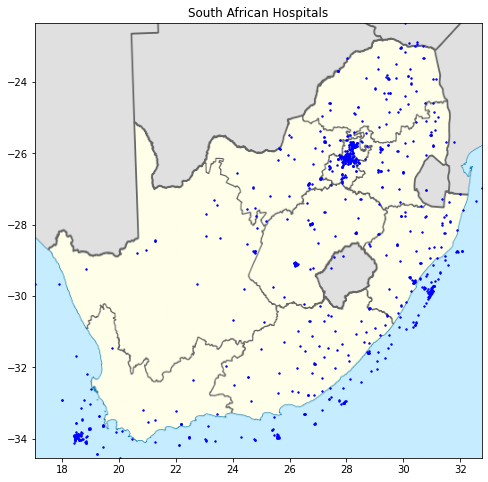

In [114]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(hospitals.Long, hospitals.Lat, zorder=2, color='b', s=2)
ax.set_title('South African Hospitals')
ax.set_xlim(coords[0], coords[1])
ax.set_ylim(coords[2], coords[3])
ax.imshow(sa_map, zorder=1, extent=coords, aspect='auto')

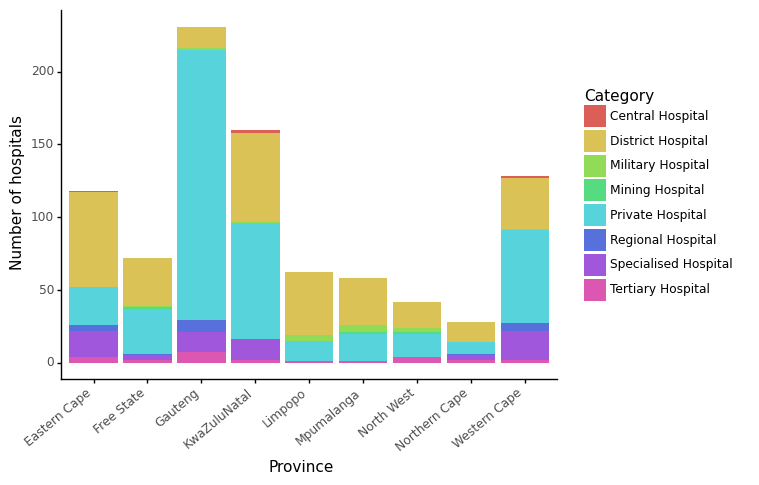

<ggplot: (-9223371936051058702)>

In [131]:
(ggplot(hospitals, aes(x='Province', fill='Category'))
    + geom_bar()
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Number of hospitals')
 )

Gauteng, KwaZulu Natal and the Western cape have the highest number of hospitals compared to other provinces. The majority of hospitals are district and private hospitals.

In [194]:
index = health_facilities[health_facilities['Population'] == '5320 50'].index
health_facilities.drop(index, inplace=True)

health_facilities['Population'] = health_facilities['Population'].astype(
    'float64')

health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'EC', 'Eastern Cape')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'FS', 'Free State')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'GT', 'Eastern Cape')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'KZN', 'KwaZulu Natal')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'LIM', 'Limpopo')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'MP', 'Mpumalanga')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'NC', 'Northern Cape')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'NW', 'North West')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'WC', 'Western Cape')

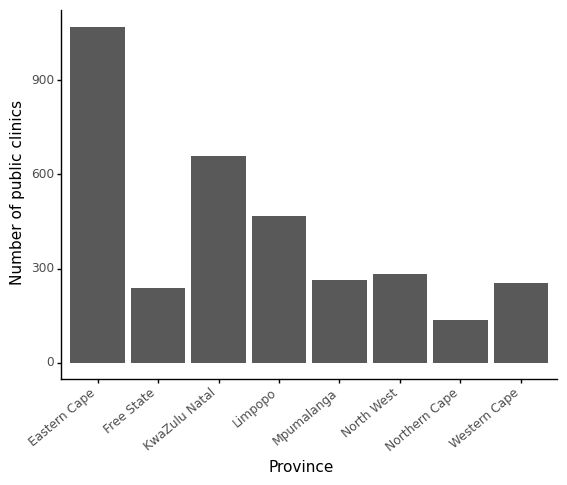

<ggplot: (-9223371936047347708)>

In [195]:
(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='No. Public clinics'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Number of public clinics')
 )

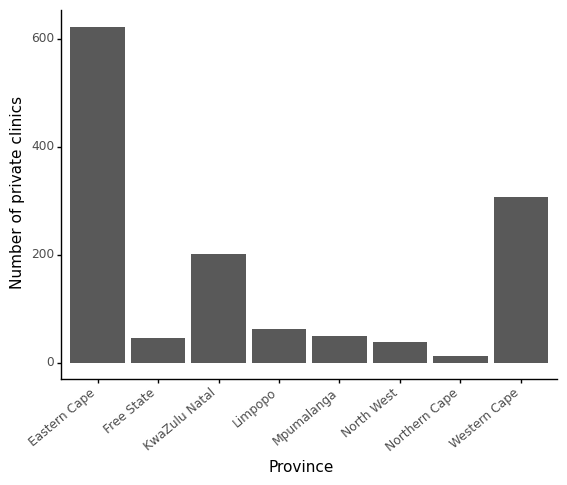

<ggplot: (-9223371936051291311)>

In [197]:
(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='No. Private Clinics'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Number of private clinics')
 )

Gauteng has the highest number of hospitals, and the majority of these are private hospitals. The majority of hospitals in Kwazulu Natal and the Western Cape are also private hospitals. The Eastern Cape has the fourth highest number of hospitals, and the highest number of public clinics. 

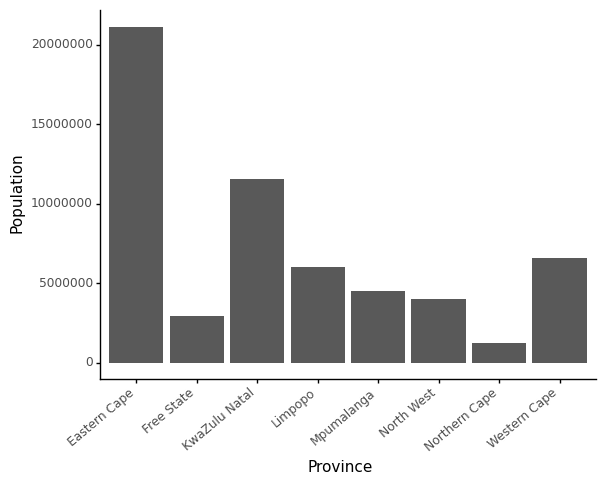

<ggplot: (-9223371936049971319)>

In [198]:
(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='Population'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Population')
 )

The provinces with the highest number of positive cases also have the the highest population numbers. 

## Effective reproductive number ($R_t$)

The effective reproductive number ($R_t$) of a virus indicates how infectious it is. It helps in estimating how many people will contract the virus from one person who is infected at a time. If the $R_t$ value is above 1 that indicates that the virus is highly infectious and will likely result in an epidemic. 

In [60]:
reproductive_rate['date'] = pd.to_datetime(
    reproductive_rate['date'], format='%Y-%m-%d')

total = reproductive_rate[reproductive_rate['state'] == 'Total RSA']
total.tail()

,state,date,ML,High_90,Low_90
1025,Total RSA,2020-08-06,1.18,1.30,1.04
1026,Total RSA,2020-08-07,0.97,1.09,0.83
1027,Total RSA,2020-08-08,0.82,0.93,0.66
1028,Total RSA,2020-08-09,0.48,0.60,0.32
1029,Total RSA,2020-08-10,0.40,0.52,0.23


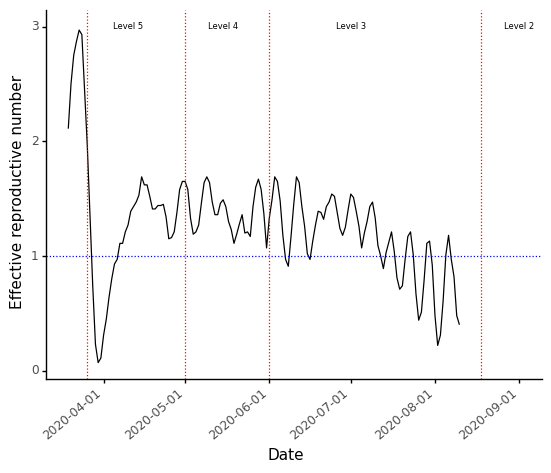

<ggplot: (96286226587)>

In [61]:
(ggplot(total, aes(x='date', y='ML'))
    + geom_line()
    + labs(x='Date', y='Effective reproductive number')
    + geom_hline(yintercept=1, linetype='dotted', color='blue')
    + geom_vline(xintercept=['2020-03-26', '2020-05-01',
                             '2020-06-01', '2020-08-18'], linetype='dotted', color='red')
    + annotate('text', x='2020-04-10', y=3, label='Level 5', size=6)
    + annotate('text', x='2020-05-15', y=3, label='Level 4', size=6)
    + annotate('text', x='2020-07-01', y=3, label='Level 3', size=6)
    + annotate('text', x='2020-09-01', y=3, label='Level 2', size=6)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

The $R_t$ for Covid-19 increased up to 3 before the lockdown was implemented. After lockdown restrictions were implemented the reproductive number remained between 1 and 2. Towards the end of level 3 lockdown the reproductive number decreased below 1 suggesting a decline in infection rates.

## Mobility report

In [111]:
mobility = mobility[mobility['province'] == 'Total']
mobility['date'] = pd.to_datetime(mobility['date'], format='%Y-%m-%d')

mobility = pd.melt(mobility, id_vars=['province', 'date'],
                   value_vars=['retail and recreation',
                               'grocery and pharmacy', 'parks',
                               'transit stations', 'workplaces',
                               'residential'])

In [112]:
mobility.head()

,province,date,variable,value
0,Total,2020-02-15,retail and recreation,4.0
1,Total,2020-02-16,retail and recreation,-3.0
2,Total,2020-02-17,retail and recreation,-10.0
3,Total,2020-02-18,retail and recreation,-12.0
4,Total,2020-02-19,retail and recreation,-12.0


This is a report that illustrates responses to social distancing during Covid-19 prepared by Google. The report shows changes in visits and length of stay in various public places (e.g restuarants, parks, grocery stores) compared to a baseline (the corresponding day of the week between 3rd January and 6th February 2020). 

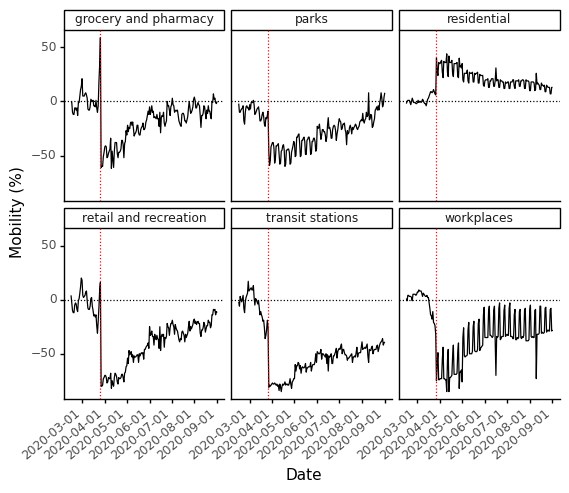

<ggplot: (100803631066)>

In [115]:
(ggplot(mobility, aes(x='date', y='value'))
    + geom_line()
    + facet_wrap('variable')
    + geom_hline(yintercept=0, linetype='dotted')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Date', y='Mobility (%)')
    + geom_vline(xintercept=['2020-03-26'], linetype='dotted', color='red')
 )

The plot above shows changes in movement before and after the lockdown. The black dashed line shows the baseline used to compare how movements have changed based on data obtained before the lockdown, and the red dashed line shows when lockdown was implemented. 

At the start of lockdown there was a decrease in the number of visits to public areas. Around the 26th of March there was a spike in the number of people visiting grocery stores and pharmacies, and this is possibly a result of people panic buying before the lockdown started. As lockdown restrictions were eased people started going out in public and spending less time at home.

# SIR Modelling

In order to model the spread of the virus without any lockdown interventions or social distancing we need to use the SIR model which requires the following parameters:
* *S* - the number of **susceptible** individuals. The assumption is that everyone in the population is susceptible and can   be infected
* *I* - the number of **infected** individuals who can spread the virus
* *R* - the number of **removed** individuals who have either passed away or recovered and cannot be re-infected

Two epidemiological quantities are also needed: the reproductive number and the recovery rate. The reproductive number of the virus when the first case was reported was 2.07.\
These are the basic equations that the model is built on:
* $\frac{dS}{dt}=-\beta.I.\frac{S}{N}$


* $\frac{dI}{dt}=\beta.I.\frac{S}{N} - \gamma.I$


* $\frac{dR}{dt}=\gamma.I$

The model assumes that the population stays the same and does not account for births and deaths that are not Covid-19 related. It also assumes that an individual who has recovered cannot get re-infected.\
The code for this model was obtained from scipython.com and the parameters used were obtained from Nyabadza _et al_., (2020).

In [137]:
# total population
N = 58775022

# recoveries & active infections
I0 = 1
R0 = 0

# susceptible
S0 = N - I0 - R0

# reproductive number
beta = 1.0598

# recovery rate
gamma = 0.4345

# social distancing parameter
rho = 0.453

# set the number of days to 180
t = np.linspace(0, 39, 40)

In [138]:
# SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = (beta * S * I / N) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [139]:
# initial conditions
y0 = S0, I0, R0
ret = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# create a dataframe for S, I and R
infection_model = pd.DataFrame(
    {'susceptible': S,
     'infected': I,
     'recovered': R,
     'days': t})

In [140]:
infection_model.tail()

,susceptible,infected,recovered,days
35,9.060921e+06,4.659275e+06,4.505483e+07,35.0
36,8.419302e+06,3.531135e+06,4.682458e+07,36.0
37,7.965662e+06,2.650130e+06,4.815923e+07,37.0
38,7.642440e+06,1.975190e+06,4.915739e+07,38.0
39,7.410667e+06,1.464868e+06,4.989949e+07,39.0


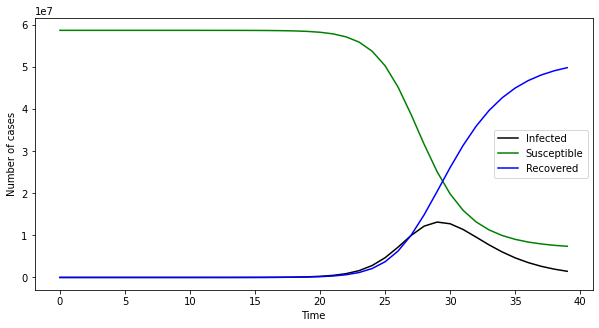

In [141]:
# plot the susceptible, infected and recovered numbers without any lockdown
plt.figure(figsize=(10, 5))

plt.plot(infection_model['days'], infection_model['infected'],
         color='black', label='Infected')
plt.plot(infection_model['days'], infection_model['susceptible'],
         color='green', label='Susceptible')
plt.plot(infection_model['days'], infection_model['recovered'],
         color='blue', label='Recovered')

plt.ylabel('Number of cases')
plt.xlabel('Time')

plt.legend()

plt.show()

The model predicts that the number of positive cases where no lockdown was implemented would have peaked 30 days after the first positive case was reported. The maximum number of infections would have reached 10 million individuals. 

A comparison of the modeled cases and the actual confirmed cases shows that the lockdown restrictions and social distancing measures put in place were effective in containing the spread of the virus and delaying the peak in infections.

# Conclusion

The data presented here shows the evolution of infections related to Covid-19 in South Africa, from the confirmation of the first case in early March. The virus was introduced in the country by individuals who had traveled to high risk countries, and 21 days after the first case was reported a national lockdown was implemented. Based on the analysis of peoples movements and the decrease in the effective reproductive number over time we can see that the implementation of the lockdown and the travel ban was effective in containing the spread of the virus. This is also evident in the comparison between modeled cases and actual confirmed cases where the actual cases show a delayed peak with only 525 242 cases confirmed.

Even though lockdown restrictions have been eased and schools have been opened, the effective reproductive number is still decreasing and the rate of infection is stabilising. This could be as a result of people being informed on how the virus spreads and following social distancing protocols that have reduced the spread. 

# References

1. https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

2. Data Science for Social Impact Research Group @ University of Pretoria, Coronavirus COVID-19 (2019-nCoV) Data Repository for South Africa. Available on: https://github.com/dsfsi/covid19za.

3. Nyabadza, F., Chirove, F., Chukwu, W., Visaya, M., 2020. Modelling the potential impact of social distancing on the COVID-19 epidemic in South Africa. medRxiv 1–17.